# Building an image embedding server with Gluon
In this notebook, we use a pre-trained model to extract image embeddings.
* **Image embeddings** are dense, high-semantic, low-dimension vector representation of images learnt by neural networks. They can directly by learnt by a model, or obtained as a byproduct of a downstream task. In this demo, we use a pre-trained classifier from the gluon model zoo to obtain those embeddings:
 1. We first import a model from the gluon model zoo locally on the notebook, that we then compress and send to S3
 1. We then use the SageMaker MXNet Serving feature to deploy the embedding model to a real-time managed endpoint. It uses the model artifact that we previously loaded to S3.
 1. We query the endpoint and visualize embeddings in a 2D scatter plot using PCA


* **More on gluon:** [gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html) is the imperative python front-end of the Apache MXNet deep learning framework. Gluon notably features specialized toolkits helping reproducing state-of-the-art architectures: [gluon-cv](https://gluon-cv.mxnet.io/), [gluon-nlp](https://gluon-nlp.mxnet.io/), [gluon-ts](https://gluon-ts.mxnet.io/). Gluon also features a number of excellent end-to-end tutorial mixing science with code such as [D2L.ai](https://classic.d2l.ai/) and [The Straight Dope](https://gluon.mxnet.io/)
* This specific demo has been developed on the `conda_mxnet_p36` kernel of a SageMaker `ml.t2.medium` Notebook instance
* For a more advanced, fully-deployed demo and an embedding server + approximate kNN pipeline see the excellent https://thomasdelteil.github.io/VisualSearch_MXNet/ from Thomas Delteil.

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**

In [8]:
import datetime
import json
import os
import subprocess as sb
import tarfile

import boto3
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import mxnet as mx
from mxnet import image, nd
from mxnet.gluon.model_zoo import vision as models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# import SageMaker tools
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel

sess = sagemaker.Session()

bucket = (
    sess.default_bucket()
)  # We use this bucket to store model weights - don't hesitate to change.
print("using bucket " + bucket)

using bucket sagemaker-us-west-2-688520471316


In [9]:
%%javascript

//disable autoscroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
# find couple open pics
pics = [
    "https://cdn.pixabay.com/photo/2016/02/16/03/42/lasso-1202578_960_720.jpg",
    "https://cdn.pixabay.com/photo/2015/09/14/20/52/cowboy-940083_1280.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/d/d3/Cowboy.1887.ws.jpg",
    "https://cdn.pixabay.com/photo/2015/05/08/05/33/cowboy-757575_960_720.jpg",
    "https://cdn.pixabay.com/photo/2017/12/03/19/08/wedding-2995641_1280.jpg",
    "https://www.maxpixel.net/static/photo/2x/Bride-And-Groom-Wedding-Ceremony-2729673.jpg",
    "https://cdn12.picryl.com/photo/2016/12/31/wedding-the-groom-bride-nature-landscapes-2c6338-1024.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/a4/%22_04_-_ITALIAN_Hypercar_GT_1_-_sport_car_racing_airscoop_intake.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Corbellati_Missile_Genf_2018.jpg/1024px-Corbellati_Missile_Genf_2018.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/7/77/JAGUAR_C-X75_HYBRID_SUPERCAR_%289098871512%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/1/1c/Girafeskoure.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/African_Leopard_Chitwa_South_Africa_Luca_Galuzzi_2004.JPG/1024px-African_Leopard_Chitwa_South_Africa_Luca_Galuzzi_2004.JPG",
    "https://www.maxpixel.net/static/photo/2x/Animal-Portrait-Fuchs-Animal-World-Wild-Animal-3532084.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Papio_papio_and_juvenile_Port_Lympne_Wild_Animal_Park.jpg/1600px-Papio_papio_and_juvenile_Port_Lympne_Wild_Animal_Park.jpg",
    "https://cdn.pixabay.com/photo/2018/07/10/22/09/raccoon-3529806_1280.jpg",
    "https://www.nps.gov/katm/learn/nature/images/bear-cubs-intro-pic.jpg?maxwidth=1200&maxheight=1200&autorotate=false",
    "https://upload.wikimedia.org/wikipedia/commons/5/52/Koenigsegg_Agera_R.jpg",
    "https://cdn.pixabay.com/photo/2017/11/09/01/49/ferrari-458-spider-2932191_1280.jpg",
]

In [11]:
# download pics
sb.call(["mkdir", "pics"])

path = "/tmp/pics/"

for p in pics:
    sb.call(["wget", p, "-P", path])

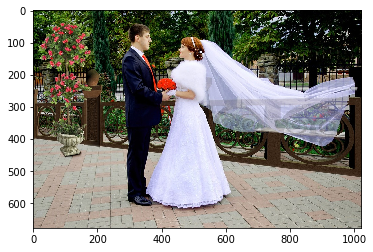

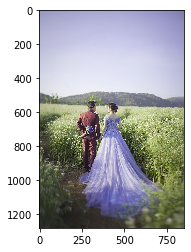

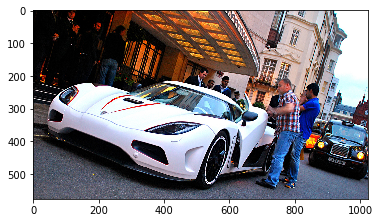

In [12]:
# reading couple images with mxnet
for p in os.listdir(path)[:3]:

    picture = mx.image.imread(os.path.join(path, p))
    plt.imshow(picture.asnumpy())
    plt.show()

## Getting embeddings from a pre-trained classifier, locally
We take models from the gluon model zoo https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html

In [13]:
modelname = "resnet152_v2"  # Other interesting options: resnet34_v2, mobilenetv2_0.5

net = models.get_model(name=modelname, pretrained=True)
emb = net.features  # get embeddings, not final probas

In [14]:
def transform(data):
    """resize, crop, normalize"""
    data = mx.image.resize_short(data, 256)  # resize
    data, _ = mx.image.center_crop(data, (224, 224))  # crop
    data = data.transpose((2, 0, 1)).expand_dims(axis=0)  # channels-first and batch size 1
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1))
    return (data.astype("float32") / 255 - rgb_mean) / rgb_std  # ImageNet-normalize


def embeddings(embmodel, pic):
    """get the image embeddings, returns an NDArray"""
    return embmodel(transform(pic)).squeeze()  # flatten if nested dimensions

In [15]:
# test locally
embeddings(emb, mx.image.imread(path + "Girafeskoure.jpg"))[:10]  # 10 first coefficients


[4.4236460e-04 7.6123536e-01 2.9450951e-03 3.0164027e-05 3.5371652e-04
 2.3311080e-01 7.9369378e-01 4.0647939e-01 3.0578811e-09 1.1853902e-01]
<NDArray 10 @cpu(0)>

## Write the embedding model in the SageMaker MXNet specification
https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/mxnet/README.rst#deploying-mxnet-models

Amazon SageMaker provides serving container for Sklearn, TensorFlow, PyTorch, Apache MXNet and Chainer. This is convenient, because we don't have to write web server code: the server is already written, in the case of MXNet it is Multi Model Server ([MMS](https://github.com/awslabs/multi-model-server), also used to server PyTorch in SageMaker) . We just have to provide model deserialization code and serving logic.

The SageMaker MXNet model server breaks request handling into three steps. Each step involves invoking a python function, with information about the request and the return-value from the previous function in the chain:

* input processing, with `input_fn(request_body, request_content_type, model)`
* prediction, with `predict_fn(input_object, model)`
* output processing, with `output_fn(prediction, content_type)`

The full serving specification is documented here https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#deploy-mxnet-models

In our specific example we don't write an `output_fn`, because `predict_fn` outputs an NDArray that can be handled to CSV or JSON by the default `output_fn`

### Create a serving script containing model deserialization and serving logic


In [16]:
%%writefile embedding_server.py

import argparse
import logging
import os

import mxnet as mx
from mxnet import nd, gluon
from mxnet.gluon.model_zoo import vision as models


# couple utilities * * * * * * * * * * * * * * * * * * * *


def transform(data):
    """resize, crop, normalize"""
    data = mx.image.resize_short(data, 256)
    data, _ = mx.image.center_crop(data, (224, 224))
    data = data.transpose((2, 0, 1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1))
    return (data.astype("float32") / 255 - rgb_mean) / rgb_std


def embeddings(embmodel, pic):
    """get the image embeddings, returns an NDArray"""
    return embmodel(transform(pic)).squeeze()  # flatten if nested dimensions


# SageMaker serving functions* * * * * * * * * * * * * * *


def model_fn(model_dir):
    """
    Load the gluon model. Called once when hosting service starts.
    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)

    assumes that the parameters artifact is {model_name}.params
    """
    modelname = os.environ["modelname"]
    net = models.get_model(name=modelname, pretrained=False, ctx=mx.cpu())
    net.load_parameters(os.path.join(model_dir, modelname + ".params"))
    logging.info("loaded parameters into model " + modelname)

    return net


def input_fn(request_body, request_content_type):
    """prepares the input"""
    output = mx.image.imdecode(request_body)
    logging.info("input_fn returns NDArray of shape " + str(output.shape))
    return output


def predict_fn(input_object, model):
    """function used for prediction"""
    emb = model.features
    return embeddings(emb, input_object)

Writing embedding_server.py


## Deploy the embedding server
We first need to send model weights to S3, as we will provide the S3 model path to Amazon SageMaker endpoint creation API

### save local model, compress and send to S3

In [17]:
# save weights
weights = modelname + ".params"
net.save_parameters(weights)

In [18]:
# compress (takes couple minutes with the resnet152)
packname = "model.tar.gz"
tar = tarfile.open(packname, "w:gz")
tar.add(weights)
tar.close()

In [19]:
# send to s3
s3 = boto3.client("s3")
s3key = "embedding-artifact"
s3.upload_file(packname, bucket, s3key + "/" + packname)

### Instantiate model and deploy

In [20]:
# instantiate model
model = MXNetModel(
    model_data="s3://{}/{}/{}".format(bucket, s3key, packname),
    role=get_execution_role(),
    py_version="py3",
    entry_point="embedding_server.py",
    framework_version="1.6.0",
    env={"modelname": modelname},
)  # we pass model name via an environment variable

In [ ]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

endpoint_key = (
    (modelname + "-embedding").replace("_", "-").replace(".", "")
    + "-"
    + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
)


predictor = model.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer(),
    deserializer=JSONDeserializer(),
    
    
)

In [46]:
predictor.endpoint_name

'mxnet-inference-2021-06-14-22-04-58-245'

In [ ]:
mxnet-inference-2021-06-14-22-04-58-245

## Submit requests to the embedding server

In [48]:

def get_emb(pic, predictor):
    """elementary function to send a picture to a predictor"""

    with open(pic, "rb") as image:
        f = image.read()
    return predictor.predict(f)


In [50]:
# test with the same image as the local inference on top of notebook
get_emb(path + "Girafeskoure.jpg", predictor)[:10]  # first 10 coefficents of the embedding

[0.0004423644859343767,
 0.7612355947494507,
 0.0029450934380292892,
 3.0164026611601003e-05,
 0.0003537166048772633,
 0.2331104278564453,
 0.7936940789222717,
 0.40647923946380615,
 3.057880615386921e-09,
 0.11853894591331482]

In [51]:
# loop through images to create embeddings of all images

picnames = os.listdir(path)

image_embs = np.expand_dims(get_emb(os.path.join(path, picnames[0]), predictor), axis=0)

for p in picnames[1:]:
    print("getting embedding for " + p)
    image_embs = np.concatenate(
        (image_embs, np.expand_dims(get_emb(os.path.join(path, p), predictor), axis=0))
    )

getting embedding for wedding-2995641_1280.jpg
getting embedding for Koenigsegg_Agera_R.jpg
getting embedding for bear-cubs-intro-pic.jpg?maxwidth=1200&maxheight=1200&autorotate=false.1
getting embedding for Cowboy.1887.ws.jpg.1
getting embedding for raccoon-3529806_1280.jpg.1
getting embedding for Bride-And-Groom-Wedding-Ceremony-2729673.jpg.1
getting embedding for 1024px-Corbellati_Missile_Genf_2018.jpg
getting embedding for Animal-Portrait-Fuchs-Animal-World-Wild-Animal-3532084.jpg
getting embedding for "_04_-_ITALIAN_Hypercar_GT_1_-_sport_car_racing_airscoop_intake.JPG.1
getting embedding for 1600px-Papio_papio_and_juvenile_Port_Lympne_Wild_Animal_Park.jpg.1
getting embedding for cowboy-940083_1280.jpg.1
getting embedding for raccoon-3529806_1280.jpg
getting embedding for Girafeskoure.jpg
getting embedding for 1024px-African_Leopard_Chitwa_South_Africa_Luca_Galuzzi_2004.JPG.1
getting embedding for Animal-Portrait-Fuchs-Animal-World-Wild-Animal-3532084.jpg.1
getting embedding for fe

### Visualize the semantic similarity in the embedding space

In [52]:
# PCA of embedding matrix
X_pca = PCA(2).fit_transform(image_embs)
emb = pd.DataFrame(X_pca, columns=["pca1", "pca2"])
emb["pic"] = picnames
emb["url"] = [os.path.join(path, p) for p in picnames]

In [53]:
def scatter(data, x, y, pic_url, pic_zoom):
    """plots a scatter plot with image thumbnails"""

    temp = data[[x, y, pic_url]].dropna().reset_index()

    ax = temp.plot(kind="scatter", x=x, y=y)

    for i in range(len(temp)):
        imagebox = OffsetImage(plt.imread(temp[pic_url][i]), zoom=pic_zoom)
        ab = AnnotationBbox(
            imagebox,
            [temp[x][i], temp[y][i]],
            xybox=(30.0, -30.0),
            xycoords="data",
            boxcoords="offset points",
            bboxprops=dict(edgecolor="r"),
        )
        ax.add_artist(ab)

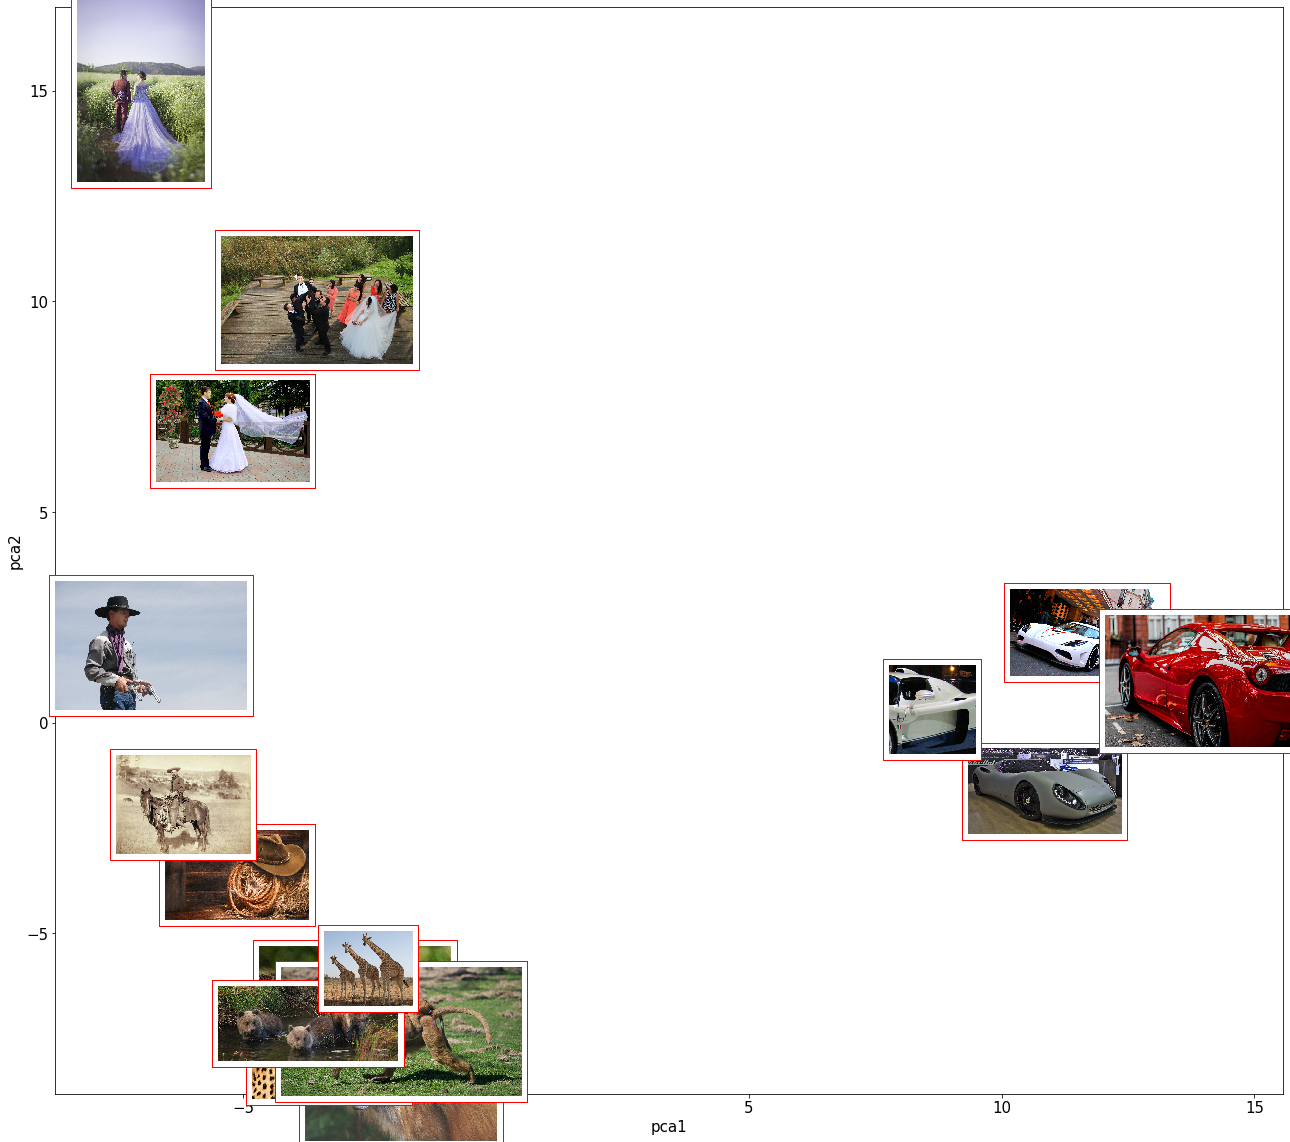

In [54]:
# some settings for visualisations
%matplotlib inline
plt.style.use("seaborn-pastel")  # set style
plt.rcParams["figure.figsize"] = [22, 20]
plt.rcParams["font.size"] = 15

scatter(data=emb, x="pca1", y="pca2", pic_url="url", pic_zoom=0.15)

### Don't forget to delete the endpoint after the demo!

In [56]:
sess.delete_endpoint(predictor.endpoint_name)